# Модель предсказания оттока клиентов телекоммуникационной компании

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

<b>Описание услуг</b>

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
- Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

<b>Описание данных</b>

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

<b>Файл contract_new.csv</b>
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.


<b>Файл personal_new.csv</b>
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

<b>Файл internet_new.csv</b>
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

<b>Файл phone_new.csv</b>
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

<b>Задача</b>

Мы будем решать задачу бинарной классификации. Целевой признак при обучении и тестировании модели - наличие или отсутствие даты EndDate. 1 - наличие, 0 - отсутствие ("No"). То есть нам необходимо эффективно находить клиентов, которые собираются уйти.

<b>Требования к решению</b>

1. Для подбора гиперпараметров модели и её тестирования нам необходимо использовать метрику ROC-AUC. Минимальный порог для успешной сдачи ROC-AUC >= 0.85.
2. Для клеинта важно, чтобы метрика была интерпретируема (чтобы он мог понять отчет), поэтому для клиента на тестовой выборке дополнительно посмотрим метрику accuracy и матрицу ошибок. 
3. Для воспроизводимости результатов обязательно задаем константу RANDOM_STATE = 29012024 и используем её при разбиении на выборки и обучении стахостических моделей.
4. Соотношение размера тренировочной выборки к тестовой - 3 к 1.

## Обзор данных

### Импорты и настройки

In [1]:
!pip install phik
!pip install -q catboost
!pip install -q lightgbm
!pip install scikit-learn==1.1.3 -q

In [2]:
import warnings
import re

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from phik import phik_matrix
import scipy.stats as st
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score,
    confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
# Сделаем настройки

# Зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

# Сбросим ограничение на число столбцов
pd.set_option('display.max_columns', None)

# Сбросим ограничение на число строк
pd.set_option('display.max_rows', None)

# Не показываем предупреждения
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Зададим константу для генератора псевдослучайных чисел
RANDOM_STATE = 29012024

# Зададим значение для генератора псевдослучайных чисел
np.random.seed(RANDOM_STATE)

In [4]:
def read_csv_file(file_path, parse_dates=None):
    try:
        return pd.read_csv(file_path, parse_dates=parse_dates)
    except FileNotFoundError:
        return pd.read_csv('https://code.s3.yandex.net/' + file_path, parse_dates=parse_dates)

df_contract = read_csv_file('/datasets/contract_new.csv', parse_dates=['BeginDate'])
df_personal = read_csv_file('/datasets/personal_new.csv')
df_internet = read_csv_file('/datasets/internet_new.csv')
df_phone = read_csv_file('/datasets/phone_new.csv')


# # Сохраним название датафреймов в переменную
# dataframes_names = ['df_contract', 'df_personal', 'df_internet', 'df_phone']

# сохраним датафреймы и имена переменных в которых они сохранены
dfs = {'df_contract': df_contract, 'df_personal': df_personal,
       'df_internet': df_internet, 'df_phone': df_phone}

### Обзор данных

Напишем функцию, которая принимает метод, который нам надо использовать и выводит результат применения этого метода ко всем датафреймам.

In [6]:
def all_df(dfs: dict, method: str, *args, **kwargs):
    for df in dfs:
        print('_______________________________________\n')
        print(f'Датафрейм {df}')
        if method == 'info':
            getattr(dfs[df], method)(*args, **kwargs)
            continue
        display(getattr(dfs[df], method)(*args, **kwargs))

all_df(dfs, "info")

_______________________________________

Датафрейм df_contract
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
_______________________________________

Датафрейм df_personal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  -

Таблицы имеют следующие размеры:
- df_contract - 7043 случая
- df_personal - 7043 случая
- df_internet - 5517 случаев
- df_phone - 6361 случай

Пропусков нет. Для названия колонок используется разный стиль написания - PascalCase и camelCase, в дальнейшем мы приведем все колонки к стандартному на Python стилю snake_case.

In [7]:
# Выведем случайные пять строк каждой таблицы
all_df(dfs, 'sample', 5, random_state=RANDOM_STATE)

_______________________________________

Датафрейм df_contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
558,2501-XWWTZ,2019-03-01,No,Month-to-month,No,Electronic check,70.20,772.2
2891,0495-RVCBF,2019-10-01,No,Month-to-month,Yes,Electronic check,79.70,321.99
77,5590-ZSKRV,2019-06-01,No,Month-to-month,No,Mailed check,54.65,437.2
1639,4690-LLKUA,2018-05-01,No,Month-to-month,Yes,Electronic check,45.05,946.05
4502,1264-BYWMS,2015-04-01,2019-01-01,Month-to-month,Yes,Electronic check,96.80,4356.0


_______________________________________

Датафрейм df_personal


,customerID,gender,SeniorCitizen,Partner,Dependents
558,2501-XWWTZ,Male,0,No,No
2891,0495-RVCBF,Female,0,No,No
77,5590-ZSKRV,Female,0,Yes,Yes
1639,4690-LLKUA,Male,1,No,No
4502,1264-BYWMS,Male,0,No,No


_______________________________________

Датафрейм df_internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
160,7018-WBJNK,Fiber optic,No,No,No,No,Yes,No
2509,0549-CYCQN,Fiber optic,No,Yes,No,No,No,No
506,3003-CMDUU,Fiber optic,No,No,No,Yes,Yes,Yes
1726,8548-AWOFC,DSL,No,No,No,Yes,No,Yes
2412,1777-JYQPJ,DSL,No,No,No,No,No,No


_______________________________________

Датафрейм df_phone


,customerID,MultipleLines
2339,3230-JCNZS,Yes
5442,0442-TDYUO,No
3969,7632-YUTXB,No
2216,8406-LNMHF,No
3654,7754-IXRMC,No


Все колонки в основном категориальные. \
В таблице df_contract две числовые колонки - MonthlyCharges(float) и TotalCharges(float). TotalCharges при этом имеет тип данных object,  видимо есть пропуски в формате строки. В этой же таблице есть две колонки с датами - BeginDate и EndDate. EndDate - целевой признак, условно категориальный, далее мы приведем его к этому типу, сейчас он содержит даты и 'No' на месте отсутствия данных. \
В таблице df_personal одна числовая-бинарная категориальная колонка SeniorCitizen. Нужно будет привети бинарные категориальные колонки к одному типу. 

In [8]:
all_df(dfs, 'describe', include='all', datetime_is_numeric=True) 

_______________________________________

Датафрейм df_contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,"7,043.00",7043
unique,7043,NaN,67,3,2,4,NaN,6658
top,4628-WQCQQ,NaN,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,NaN,5942,3875,4171,2365,NaN,11
mean,NaN,2017-04-30 13:01:50.918642688,NaN,NaN,NaN,NaN,64.76,NaN
min,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,18.25,NaN
25%,NaN,2015-06-01 00:00:00,NaN,NaN,NaN,NaN,35.50,NaN
50%,NaN,2017-09-01 00:00:00,NaN,NaN,NaN,NaN,70.35,NaN
75%,NaN,2019-04-01 00:00:00,NaN,NaN,NaN,NaN,89.85,NaN
max,NaN,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,118.75,NaN


_______________________________________

Датафрейм df_personal


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,"7,043.00",7043,7043
unique,7043,2,NaN,2,2
top,4628-WQCQQ,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.16,NaN,NaN
std,NaN,NaN,0.37,NaN,NaN
min,NaN,NaN,0.00,NaN,NaN
25%,NaN,NaN,0.00,NaN,NaN
50%,NaN,NaN,0.00,NaN,NaN
75%,NaN,NaN,0.00,NaN,NaN


_______________________________________

Датафрейм df_internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6152-ONASV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


_______________________________________

Датафрейм df_phone


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4628-WQCQQ,No
freq,1,3390


Выявлены следующие особенности данных: \
В таблице df_contract:
- в колонке TotalCharges показатель top равен пустой строке, и встречается он 11 раз, далее нужно будет разобраться в причинах таких пропусков. 
- в целевом столбце EndDate имеется серьезный дисбаланс классов: из семи тысяч случаев, шесть - негативные.
- в столбце Type также есть дисбаланс: классов три, при этом доминирующий занимает более половины случаев.
- данные нам предоставлены за период с 2013.10.01 по 2020.02.01, в среднем - 2017.09.01. Данные довольно старые, если исспледование проводится в 2020 году, то лучшим выбором были бы данные за последние несколько лет, так как поведение людей с течением времени может меняться.

В таблице df_personal:
- в колонке SeniorCitizen серьезный дисбаланс - пенсионеров 16% от размера датафрейма. 
- в колонке Dependents небольшой дисбаланс - пользователей с детьми 30% от количества случаев.

## Исследовательский анализ и предобработка данных

### Предобработка

#### Пропуски в TotalCharges

Прежде чем формировать графики, приведем TotalCharges к типу float. Посмотрим на случаи с пустыми строками в TotalCharges.

In [9]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Судя по дате начала действия договора, на момент формирования отчета эти клиенты еще не успели оплатить услуги, но судя по заполненной MonthlyCharges - тут неконсистентность базы данных, видимо клиенты находились в состоянии оплаты - подтверждения платежа. Заменим пропуски на значение из MonthlyCharges.

In [10]:
df_contract.loc[df_contract['TotalCharges'] == ' ', 'TotalCharges'] = df_contract['MonthlyCharges']

# Проверим
df_contract[df_contract['customerID'] == '1371-DWPAZ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05


In [11]:
# Приведем к типу float
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float64')

# Проверим
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


#### SeniorCitizen - приведение к формату

Также, чтобы наши графики были информативнее, в таблице df_personal заменим значения SeniorCitizen с числовых 0 и 1, на 'No' и 'Yes'.

In [12]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

# Проверим
df_personal.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,No,Yes,Yes
7039,2234-XADUH,Female,No,Yes,Yes
7040,4801-JZAZL,Female,No,Yes,Yes
7041,8361-LTMKD,Male,Yes,Yes,No
7042,3186-AJIEK,Male,No,No,No


#### Изменение названия колонок

Привдем названия колонок к змеиному регистру.

In [13]:
for df in dfs:
    df = eval(df)
    df.rename(columns={'customerID': 'customer_id'}, inplace=True)
    df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower()
                  if col != 'StreamingTV' else 'streaming_tv'
                  for col in df.columns]
    df.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-nu

#### Обогащение данных.

Так как чтобы не было утечки данных, при обучении модели нельзя использовать в том числе признаки с абсолютными датами, сформируем еще один признак с количеством дней, которые человек является клиентом компании. \
У нас есть дата заключения договора и дата окончания, но не везде, для формирования этого столбца - заменим 'No' на 'текущую дату' - 2020.02.01. А чтобы далее на графике посмотреть динамику оттока клиентов - заранее сохраним значения, которые не являются 'No', в отдельную переменную. 

Чтобы не потерять целевой признак, вынесем его в отдельный столбец, дополнительно сделав бинарным, таким образом получим признак, который будет показывать, разорван ли договор или нет.

In [14]:
# Сформируем новый столбец
df_contract['breaking_contract'] = df_contract['end_date'].apply(lambda x: 0 if x == 'No' else 1)

# Проверим
df_contract.tail(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,breaking_contract
7033,9767-FFLEM,2016-12-01,No,Month-to-month,Yes,Credit card (automatic),69.50,"2,693.82",0
7034,0639-TSIQW,2014-03-01,2015-11-01,Month-to-month,Yes,Credit card (automatic),102.95,"2,059.00",1
7035,8456-QDAVC,2018-07-01,No,Month-to-month,Yes,Bank transfer (automatic),78.70,"1,585.02",0
7036,7750-EYXWZ,2019-02-01,No,One year,No,Electronic check,60.65,727.80,0
7037,2569-WGERO,2014-02-01,No,Two year,Yes,Bank transfer (automatic),21.15,"1,553.26",0
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,"2,035.20",0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,"7,430.40",0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,0
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.80,0
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,"7,251.82",0


Сохраним в отдельную переменную даты разрывов договоров.

In [15]:
copy_df_contract = df_contract.copy()
copy_df_contract = copy_df_contract[copy_df_contract['end_date'] != 'No']
copy_df_contract['end_date'] = pd.to_datetime(copy_df_contract['end_date'], format='%Y-%m-%d')

Заменим 'No' в EndDate, на 'текущую' дату. Приведем к формату datetime.

In [16]:
df_contract['end_date'] = df_contract['end_date'].replace('No', '2020-02-01')

df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

# Проверим
df_contract.tail(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,breaking_contract
7033,9767-FFLEM,2016-12-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),69.50,"2,693.82",0
7034,0639-TSIQW,2014-03-01,2015-11-01,Month-to-month,Yes,Credit card (automatic),102.95,"2,059.00",1
7035,8456-QDAVC,2018-07-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),78.70,"1,585.02",0
7036,7750-EYXWZ,2019-02-01,2020-02-01,One year,No,Electronic check,60.65,727.80,0
7037,2569-WGERO,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),21.15,"1,553.26",0
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,"2,035.20",0
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,"7,430.40",0
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,0
7041,8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.80,0
7042,3186-AJIEK,2014-08-01,2020-02-01,Two year,Yes,Bank transfer (automatic),105.65,"7,251.82",0


Сформируем новую колонку с количеством дней, которые пользователь является клиентом компании.

In [17]:
df_contract['duration'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

# Удалим end_date, она нам больше не понадобится
df_contract.drop('end_date', axis=1, inplace=True)

# Проверим
df_contract.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,breaking_contract,duration
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,"2,071.84",0,1036
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,"1,960.60",0,1371
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


### Графики

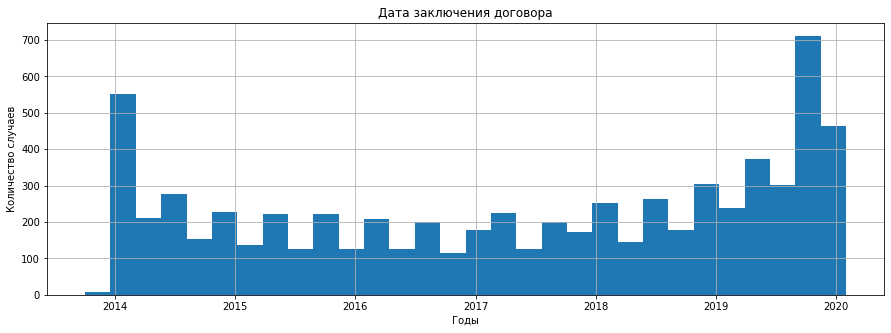

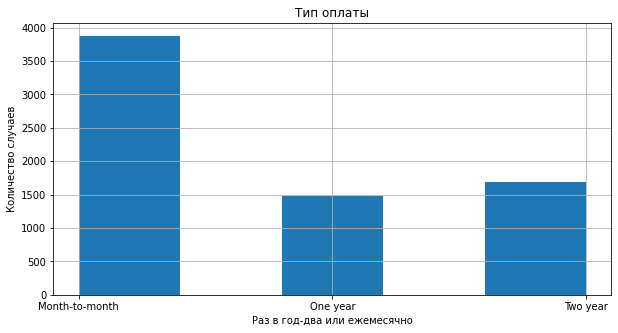

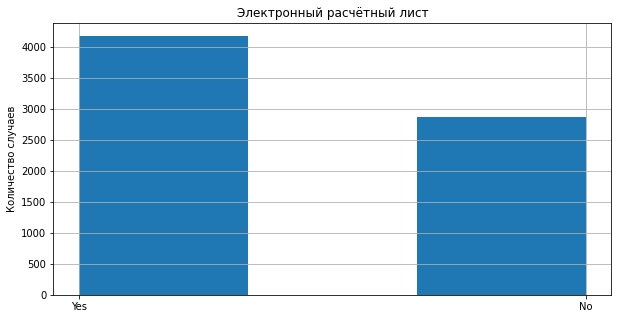

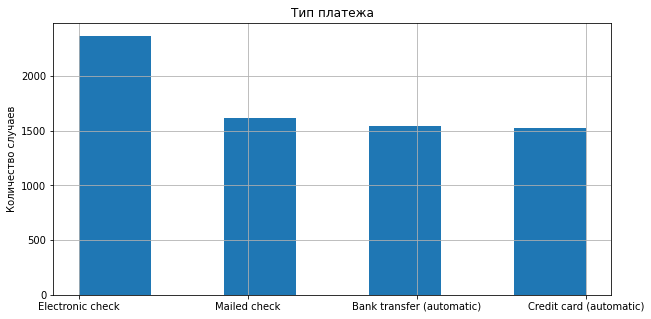

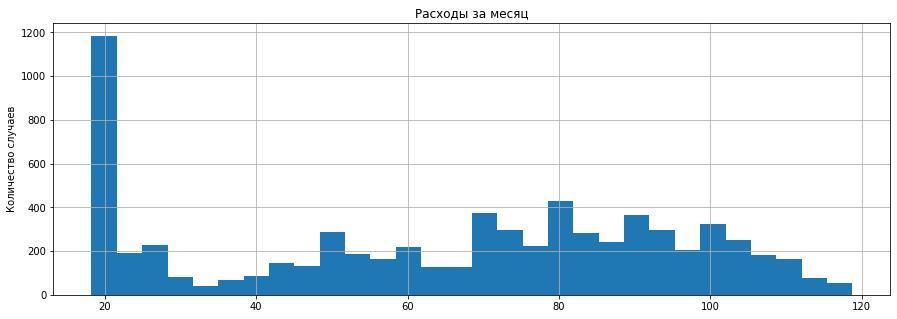

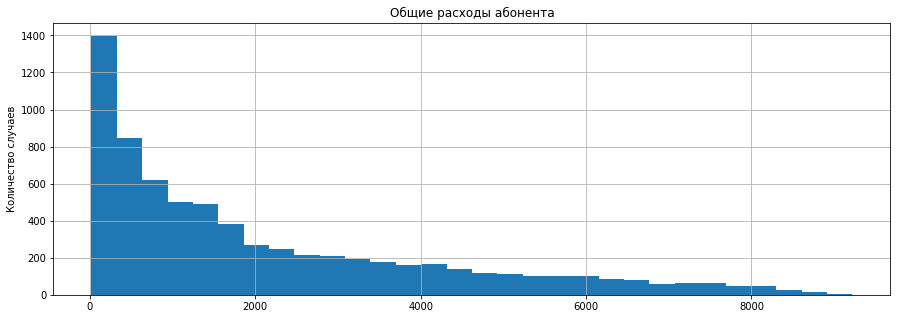

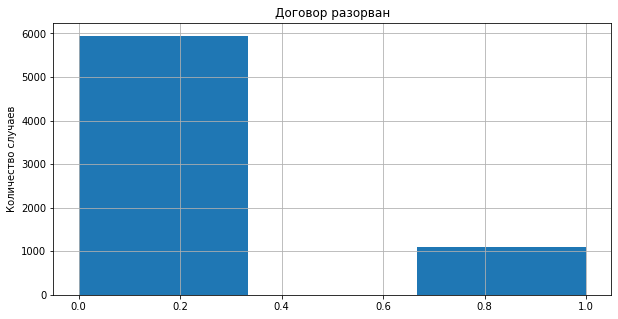

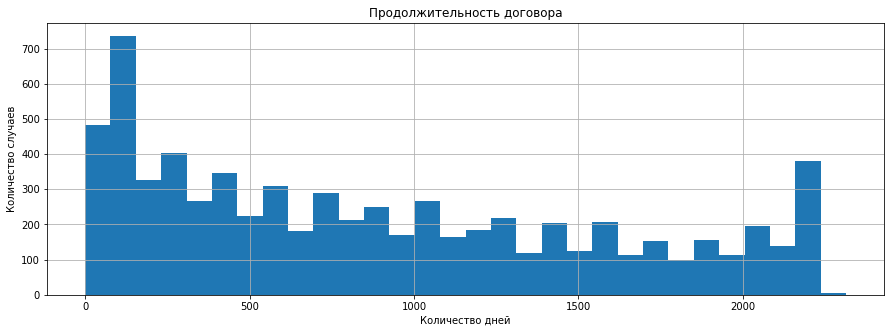

In [18]:
def graph(df, cols):
    """Функция для отображения графиков"""
    for col in cols:
        plt.figure(figsize=(col[4], 5))
        df[col[0]].hist(bins=col[3])
        plt.title(col[1])
        plt.xlabel(col[2])
        plt.ylabel('Количество случаев')
        plt.show()

contract =[['begin_date', 'Дата заключения договора', 'Годы', 30, 15],
           ['type', 'Тип оплаты', 'Раз в год-два или ежемесячно', 5, 10],
           ['paperless_billing', 'Электронный расчётный лист', '', 3, 10],
           ['payment_method', 'Тип платежа', '', 7, 10],
           ['monthly_charges', 'Расходы за месяц', '', 30, 15],
           ['total_charges', 'Общие расходы абонента', '', 30, 15],
           ['breaking_contract', 'Договор разорван', '', 3, 10],
           ['duration', 'Продолжительность договора', 'Количество дней', 30, 15]]

graph(df_contract, contract)

Можно сделать выводы:
- количество новых абонентов сильно (более чем в 2 раза) увеличилось в последние полтора года. Ранее с 2015 по 2017 год наблюдалось плавное снижение количества абонентов, после 2017 был плавный рост. 
- за услуги клиенты предпочитают платить ежемесячно, в два раза менее востребованы услуги оплаты на один и два года вперед. 
- электронный рассчотный счет предпочитают иметь большая часть клиентов. 
- клиенты предпочитают платить через электронный чек, менее востребована оплата через почтовый чек. Автоматические платежи с помощью банковского перевода и кредитной карты пользуются одинаковой популярностью.
- на графике расходов за месяц видно, что большинство клиентов тратят на услуги сумму в районе 20 долларов(?), видны небольшие локальные пики в районе круглых цифр - 50, 60, 70, 80, 90 и  100 долларов.
- на графике общих расходов абонента график с пиком в районе нуля и длинным тонким хвостом. Это говорит о том, что очень много новых клиентов, которые еще не успели потратить средства.
- в выборке клиентов разорвавших договор сильно меньше, чем действующих. 
- на графике продолжительности договора в днях виден пик в районе 100 дней, второй пик на другом конце графика - примерно на 2250 дне, между этими пиками наблюдается плавное снижение графика. Этот график очень похож на перевернутый график даты заключения договора, сравнив их, можно сделать вывод, что за годы компания сохранила только половину наиболее старых клиентов.

Посмотрим на сохраненные данные по датам разрывов догворов. Выведем график.

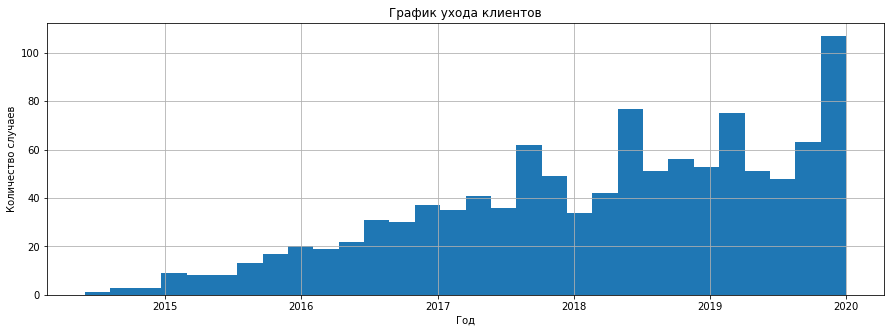

In [19]:
plt.figure(figsize=(15, 5))
copy_df_contract['end_date'].hist(bins=30)
plt.title('График ухода клиентов')
plt.xlabel('Год')
plt.ylabel('Количество случаев')
plt.show()

График скошен вправо, пик в районе 2020 года, локальные пики в конце 2017, середине 2018 и начале 2019 года.

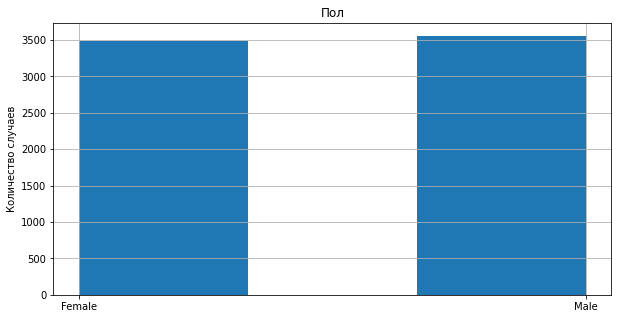

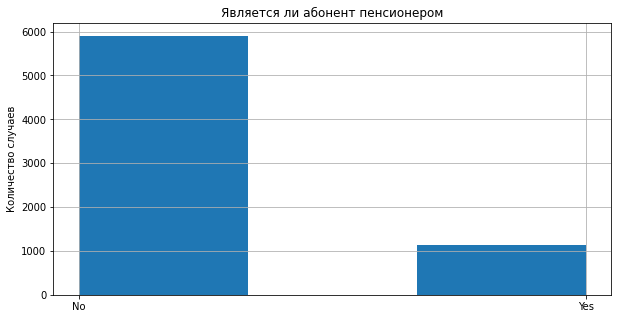

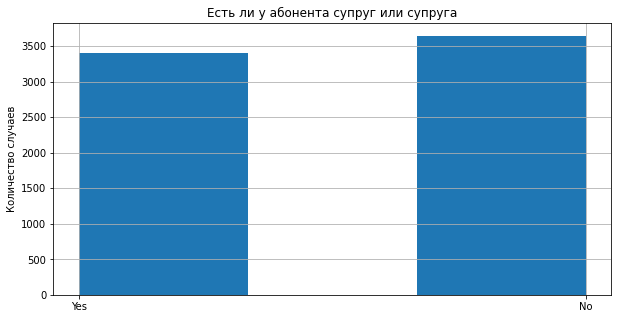

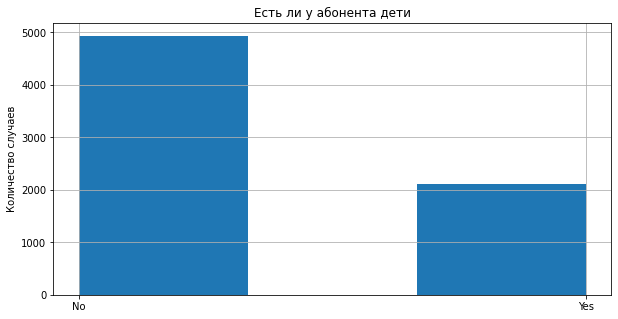

In [20]:
personal = [
    ['gender', 'Пол', '', 3, 10],
    ['senior_citizen', 'Является ли абонент пенсионером', '', 3, 10],
    ['partner', 'Есть ли у абонента супруг или супруга', '', 3, 10],
    ['dependents', 'Есть ли у абонента дети', '', 3, 10]
]

graph(df_personal, personal)

- Соотношение полов у абонентов примерно одинаковое.
- Пенсионеров из них примерно 16 процентов.
- Замужних/женатых клиентов немного меньше, чем неженатых/незамужних, в целом соотношение примерно одинаковое.
- У большинства клиентов нет детей.

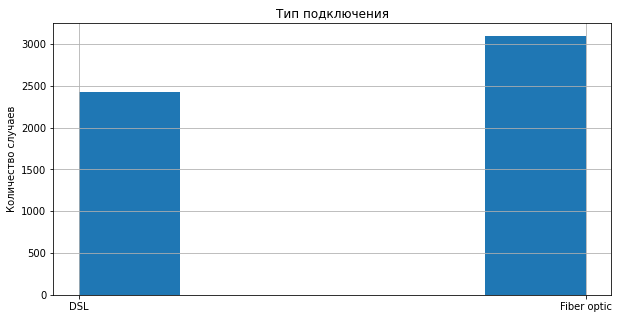

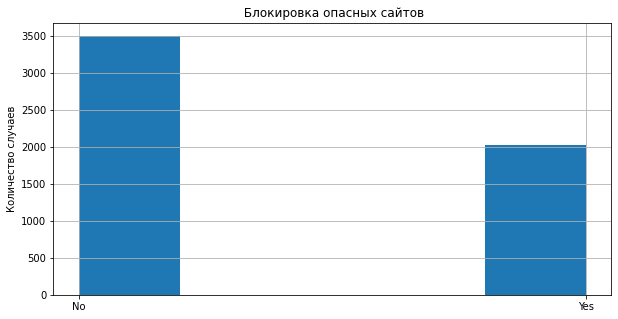

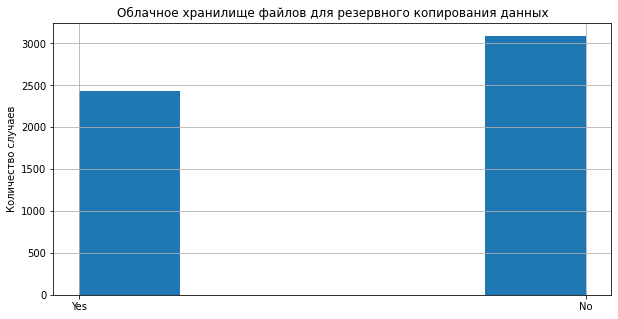

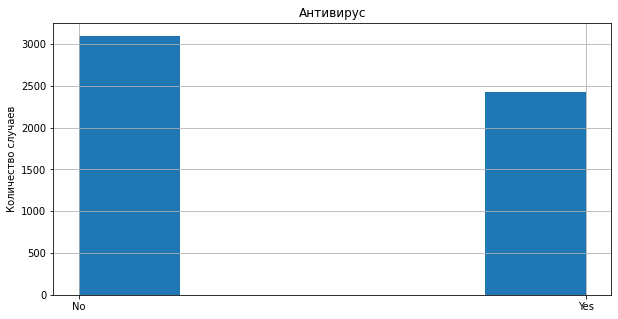

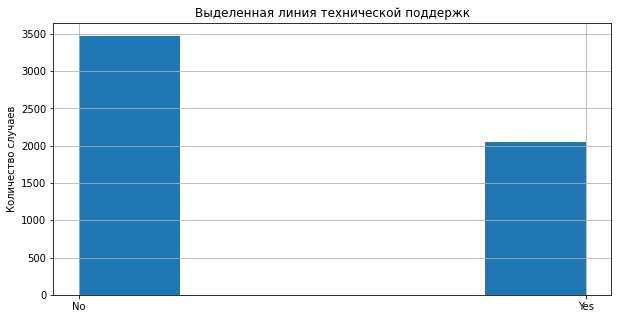

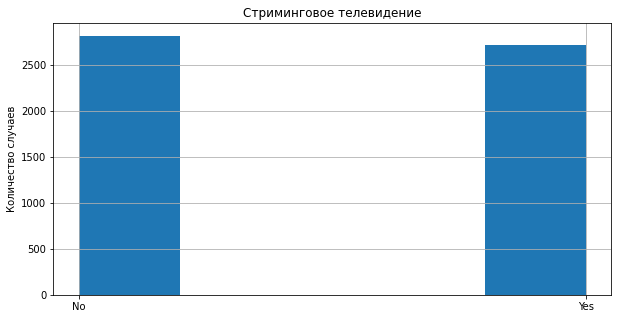

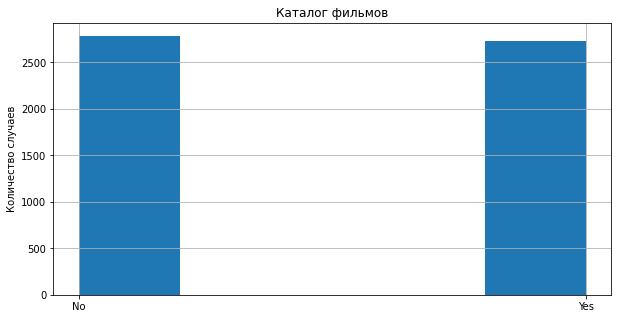

In [21]:
internet = [
    ['internet_service', 'Тип подключения', '', 5, 10],
    ['online_security', ' Блокировка опасных сайтов', '', 5, 10],
    ['online_backup', 'Облачное хранилище файлов для резервного копирования данных', '', 5, 10],
    ['device_protection', 'Антивирус', '', 5, 10],
    ['tech_support', 'Выделенная линия технической поддержк', '', 5, 10],
    ['streaming_tv', 'Стриминговое телевидение', '', 5, 10],
    ['streaming_movies', 'Каталог фильмов', '', 5, 10],
]

graph(df_internet, internet)

- по оптоволокну подключено немного больше клиентов, чем по DSL соединению.
- клиентов, которые подключали услугу блокировки опасных сайтов в два раза меньше, чем тех, которые этого не делают.
- абонентов, пользующихся услугой облачного хранилища данных меньше, чем тех, которые данной услугой не пользуются.
- антивирусом пользуются немного меньше абонентов, чем тех, которые не используют данную услугу.
- абонентов подключающих выделенную линию технической поддержки в два раза меньше, чем тех, которые не пользуются данной услугой.
- стриминговое тв довольно популярно у пользователей, данную услугу подключило половина абонентов. 
- услугой каталога фильмов также пользуются примерно половина абонентов. 

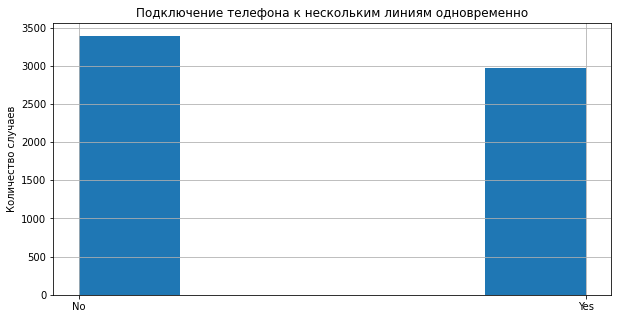

In [22]:
phone = [
    ['multiple_lines', 'Подключение телефона к нескольким линиям одновременно', '', 5, 10],
]

graph(df_phone, phone)

Пользователей, которые пользуются услугой подключения телефона к нескльким линиям немного меньше, чем тех, кто не пользуется данной услугой.

### Кореляция

Для подсчета корреляции с категориями не подходит метод corr из pandas, так как нельзя рассчитывать корреляцию Пирсона для категориальных переменных. Для категориальных данных используются: корреляция Крамера, корреляция Метьюса. Для оценки связи между двумя различными по типу признаками можно использовать коэффициент взаимной информации, поэтому мы будем использовать библиотеку phik, поторая позволяет измерять силу и направление взаимосвязи между категориальными и количественными переменными.

Напишем функцию для быстрого вывода тепловой карты.

In [23]:
def heatmap(df, title, interval_cols=None):
    """Функция для вывода тепловой карты."""
    plt.figure(figsize=(15,10))
    sns.heatmap(phik_matrix(df, interval_cols=interval_cols), annot=True, linewidths=.5, cmap='flare')
    plt.title(title)
    plt.show()

#### df_contract

phik плохо работает с признаками в формате даты, нужно либо удалять его, либо приводить к типу int. Воспользуемся вторым способом. 

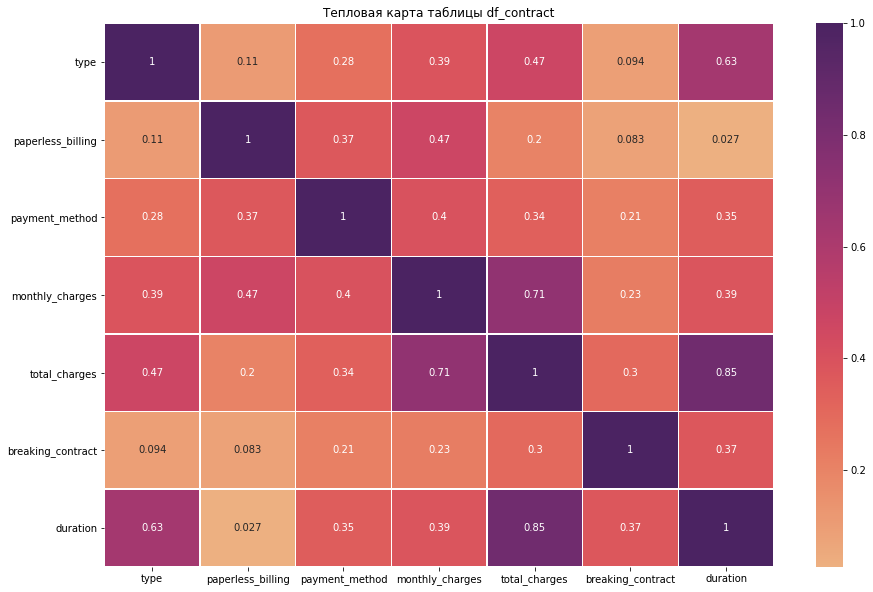

In [24]:
copy_df_contract = df_contract
copy_df_contract = copy_df_contract.drop(['begin_date', 'customer_id'], axis=1)

heatmap(copy_df_contract, 'Тепловая карта таблицы df_contract', ['monthly_charges', 'total_charges', 'duration'])

Признаки duration, begin_date и total_charges очень сильно коррелируют. Чтобы избежать проблемы мультиколлинеарности, оставим только один из них - duration.

In [25]:
df_contract = df_contract.drop(['begin_date', 'total_charges'], axis=1)

# Проверим
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   breaking_contract  7043 non-null   int64  
 6   duration           7043 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 385.3+ KB


#### df_personal

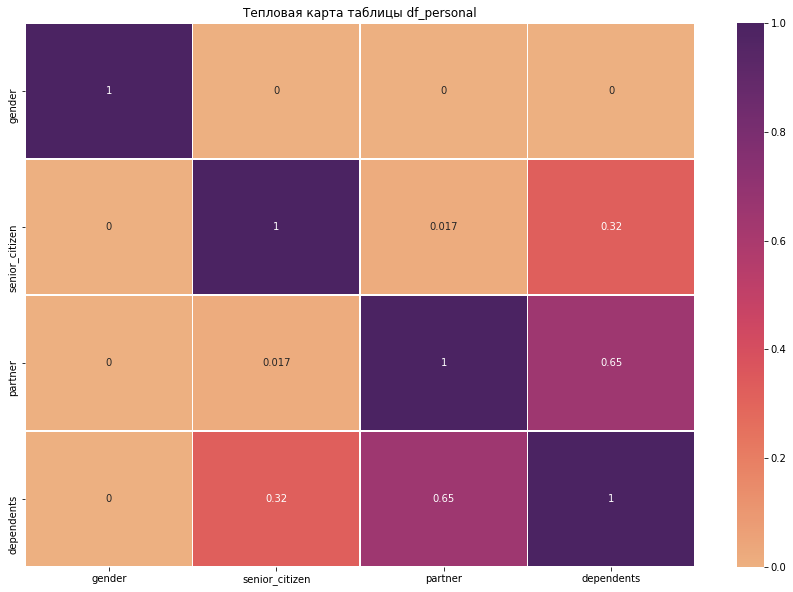

In [26]:
heatmap(df_personal.drop('customer_id', axis=1), 'Тепловая карта таблицы df_personal')

Колонка partner довольно сильно коррелирует с колонкой dependents, что логично. Признак пола не коррелирует вообще ни с чем.

#### df_internet

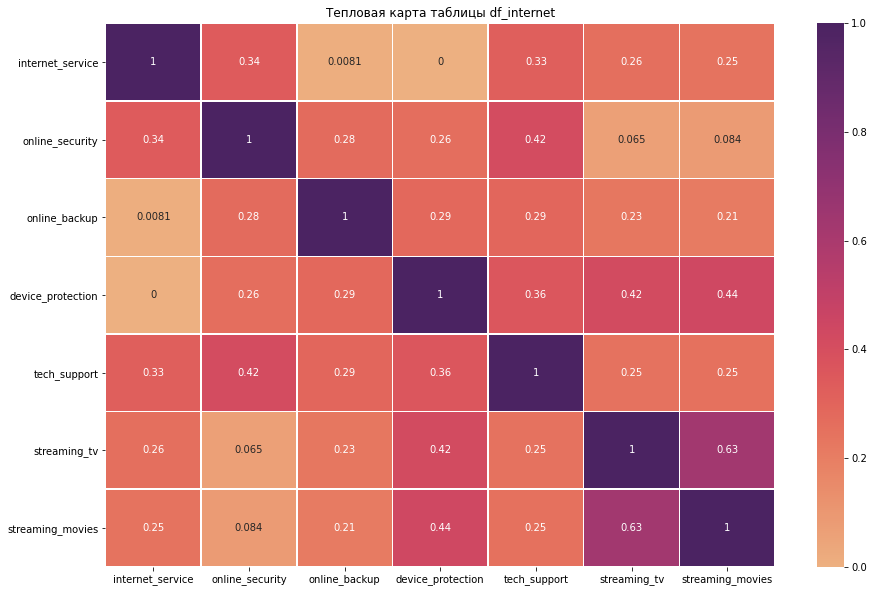

In [27]:
heatmap(df_internet.drop('customer_id', axis=1), 'Тепловая карта таблицы df_internet')

Сильно корреклируют между собой стриминговое телевидение и каталог фильмов. Интересно, что нет никакой связи между типом подключения и использованием услуги антивируса, но в то же время тип подключения умеренно коррелирует почти со всеми остальными услугами.

Таблицу df_phone проверим на корреляцию после объединения датафреймов, так как там всего две колонки, одна из которых - содержит уникальные значения.

## Объединение таблиц

В таблице df_contract у нас находится целевой признак, поэтому в итоговый датафрейм должны войти все стоки из этой таблицы. Остальные три датафрейма будем присоединять по общему столбцу - признаку с id абонента. 

In [28]:
df = (
    df_contract
    .merge(df_personal, how='outer', on='customer_id')
    .merge(df_internet, how='outer', on='customer_id')
    .merge(df_phone, how='outer', on='customer_id')
)

# Проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   breaking_contract  7043 non-null   int64  
 6   duration           7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv       5517 

In [29]:
# Выведем на экран первые пять строк объединенного датафрейма
df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,breaking_contract,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


Колонки с информацией о подключенных услугах содержат пропуски. Это говорит о том, что пользователь не использует данный тип услуг, поэтому заменим пропуски на 'No'.

In [30]:
df.fillna('No one', inplace=True)

df.isna().sum()

customer_id          0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
breaking_contract    0
duration             0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

In [31]:
df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,breaking_contract,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No one
1,5575-GNVDE,One year,No,Mailed check,56.95,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No one
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


##  Исследовательский анализ и предобработка данных объединённого датафрейма

Выведем общую информацию по датафрейму.

In [32]:
df.describe(include='all', datetime_is_numeric=True)

,customer_id,type,paperless_billing,payment_method,monthly_charges,breaking_contract,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
count,7043,7043,7043,7043,"7,043.00","7,043.00","7,043.00",7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,3,2,4,NaN,NaN,NaN,2,2,2,2,3,3,3,3,3,3,3,3
top,4628-WQCQQ,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,Male,No,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,3875,4171,2365,NaN,NaN,NaN,3555,5901,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,64.76,0.16,898.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,30.09,0.36,683.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,18.25,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,35.50,0.00,276.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,70.35,0.00,761.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,89.85,0.00,"1,461.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Графики

Выведем графики. Сформируем портрет ушедшего абонента. 

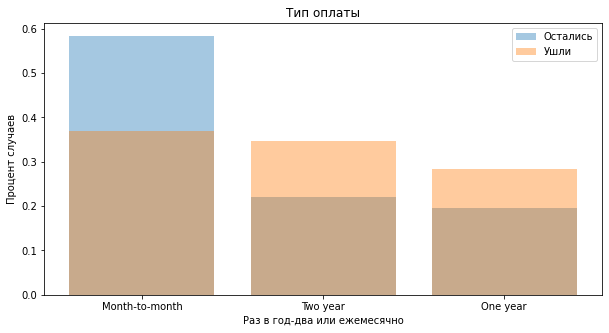

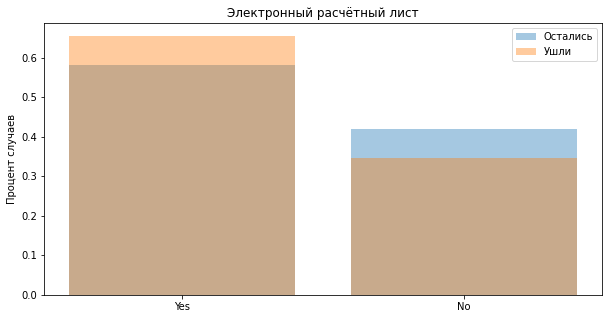

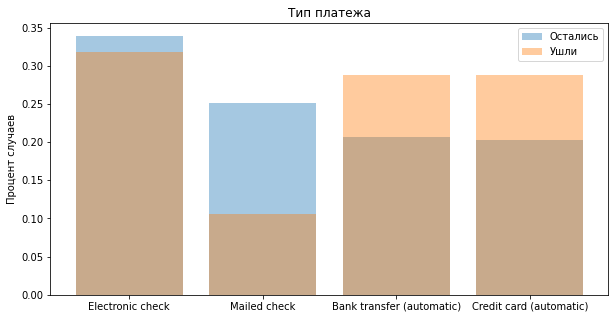

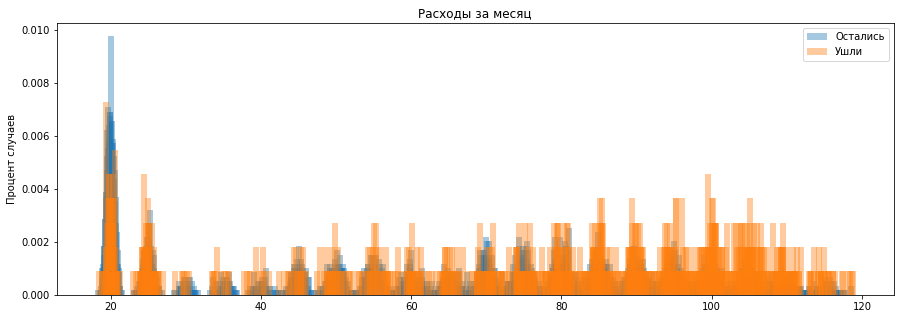

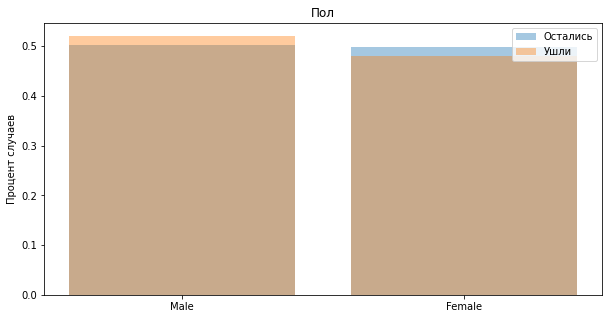

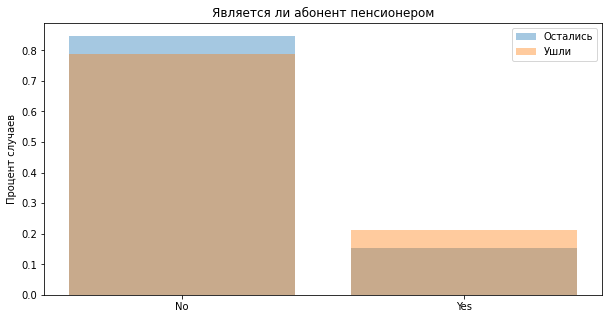

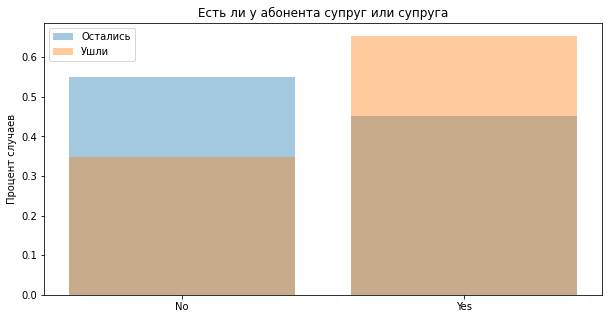

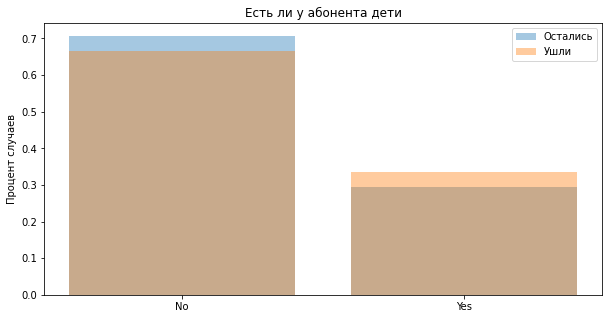

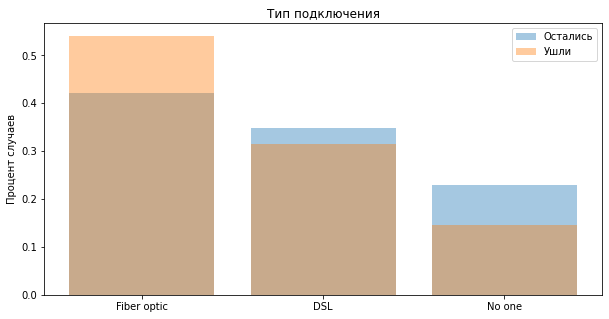

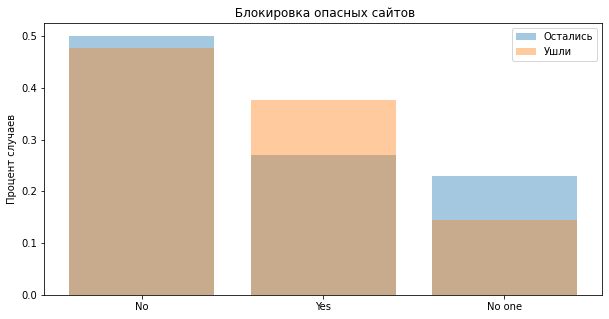

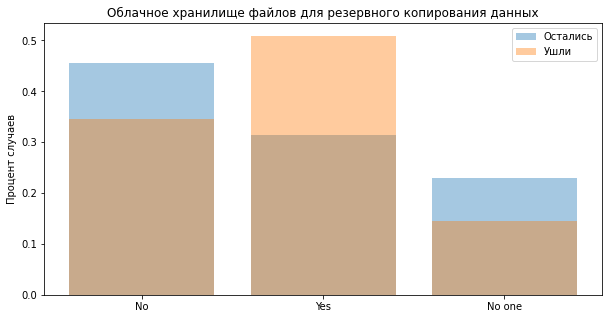

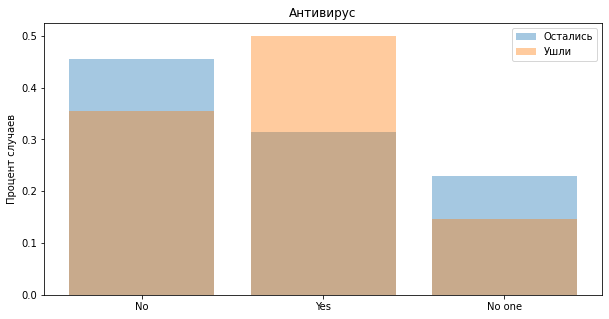

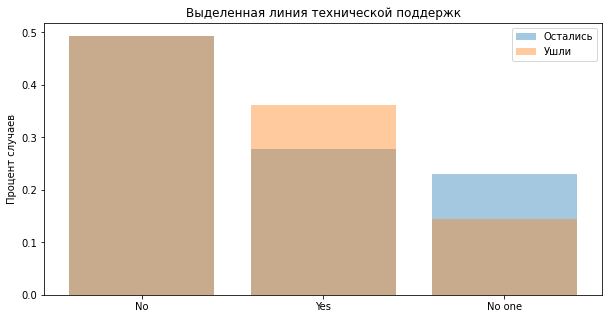

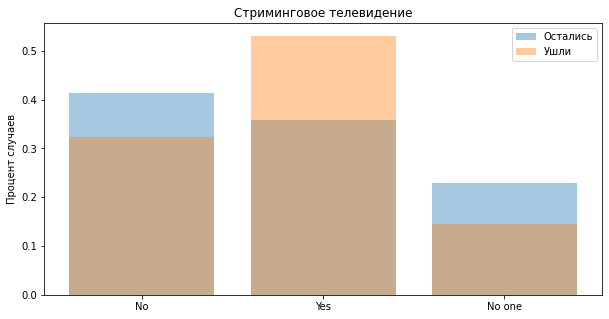

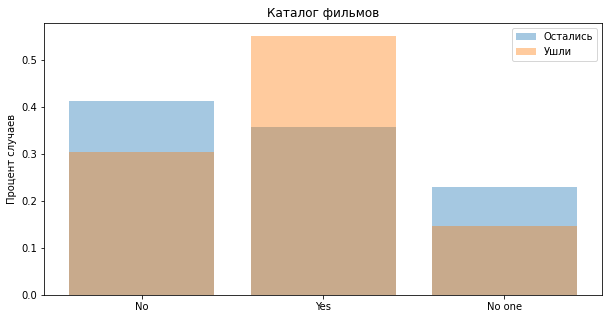

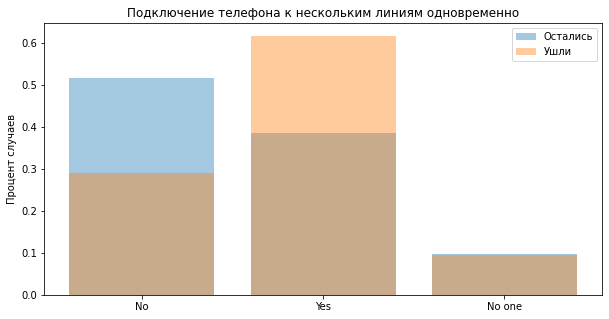

In [33]:
# Объединим списки с ранее сформированной для отображения графиков информацией
cols = contract + personal + internet + phone

# Уберем из списка удаленные ранее колонки
cols = [col for col in cols if col[0] not in ['begin_date', 'total_charges']]

# graph(df, cols)

# Сохраним выборки
class_0, class_1 = df.query('breaking_contract == 0'), df.query('breaking_contract == 1')

for col in cols:
    if col[0] in ['breaking_contract', 'duration']:
        continue
    plt.figure(figsize=(col[4], 5))
    val_0 = class_0[col[0]].value_counts(normalize=True)
    val_1 = class_1[col[0]].value_counts(normalize=True)
    plt.bar(val_0.index, val_0.values, label='Остались', alpha=0.4)
    plt.bar(val_1.index, val_1.values, label='Ушли', alpha=0.4)
    plt.title(col[1])
    plt.xlabel(col[2])
    plt.ylabel('Процент случаев')
    plt.legend()
    plt.show()

В признаках из таблиц услуг (internet_new.csv и phone_new.csv) появиилась третья категория - 'No one'.

Составим портрет разорвавшего контракт клиента:
- оплачивает услуги на год или два вперед;
- чаще имеет электронный расчетный счет;
- проставляет автоматическую оплату;
- это врятли пенсионер;
- абонент находится в браке, но почти не важно, если ли у абонента дети;
- тип подключения этого абонента чаще - оповолокно;
- пользуется услугами облачного хранилища данных, антивирусом, стримминговым тв, каталогом фильмов, немного реже - услугами блокировки опасных сайтов и выделенной линией технической поддержки;
- использует услугу подключения телефона к нескольким линиям одновременно. При этом оставщихся клиентов больше среди тех, что пользовались, но отключили данную услугу, чем среди тех, что не включали данную услугу вовсе. 

При этом клиент, который чаще остается это клиент, который не пользуется интернетом вовсе. Также интересно, что среди абонентов которые не используют услугу подключения телефона к нескольким линиям, клиенты, которые использовали эту услугу, но отключили со временем почти в два раза реже уходят, чем те, которые не использовали эту услугу вовсе. Возможно это связано с продолжительностью контракта, так как в настоящее время, мало кто пользуется услугой телефонной линии.

### Корреляция

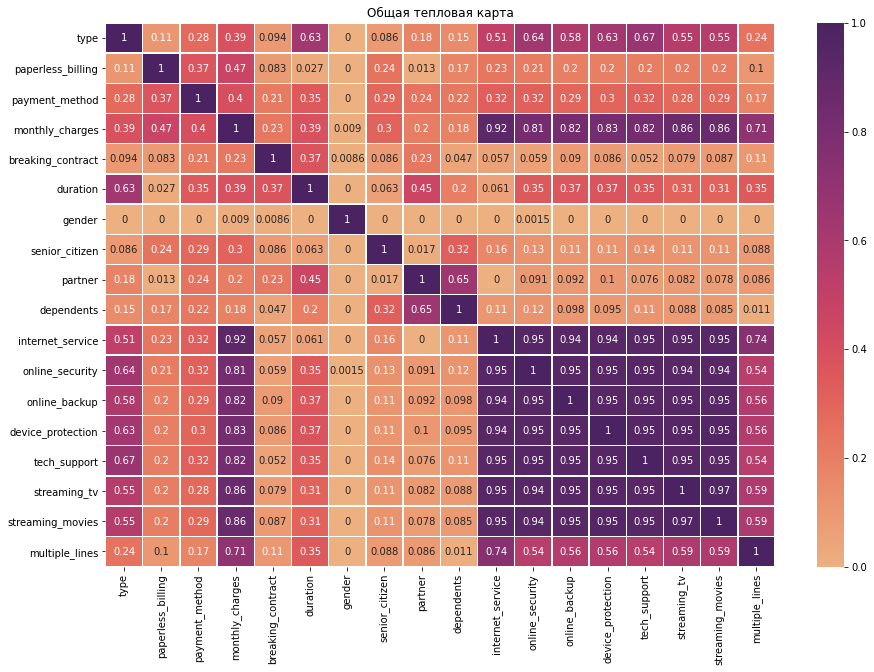

In [34]:
heatmap(df.drop('customer_id', axis=1), 'Общая тепловая карта', ['monthly_charges', 'duration'])

Признак monthly_charges сильно коррелирует с столбцами internet_service, streaming_tv, streaming_movies. Удалим этот признак. Его также нужно удалить, потому что тарифы с течением времени растут, и что пять лет назад было большими затратами, сегодня таковыми не являются, инфляция.

Почти полностью коррелируют между собой признаки из таблицы интернет услуг. Оставим из них только один признак - online_backup, так как у него самый высокий размер корреляции с целевой переменной.

Также удалим, как неинформативные, признаки с id клиента и его полом. Пол также стоит удалить, чтобы в будущем не было проблем с позможным ужесточением законодательства в плане дискриминации по половому признаку.

In [35]:
df = df.drop(['customer_id', 'gender', 'monthly_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv'], axis=1)

# Проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               7043 non-null   object
 1   paperless_billing  7043 non-null   object
 2   payment_method     7043 non-null   object
 3   breaking_contract  7043 non-null   int64 
 4   duration           7043 non-null   int64 
 5   senior_citizen     7043 non-null   object
 6   partner            7043 non-null   object
 7   dependents         7043 non-null   object
 8   streaming_movies   7043 non-null   object
 9   multiple_lines     7043 non-null   object
dtypes: int64(2), object(8)
memory usage: 605.3+ KB


## Подготовка признаков

Разделем датафрейм на обучающую и тестовую выборки. \
Выделим в отдельные переменные названия категориальных и числовых колонок. \
Для модели LGBMRClassifier сделаем отдельный features_train, в котором заменим тип категориальных колонок с 'object', на 'category'.

### Разделение на обучающую и тестовую выборки

In [36]:
target_train, target_test, features_train, features_test = train_test_split(
    df['breaking_contract'], df.drop('breaking_contract', axis=1),
    test_size=0.25, random_state=RANDOM_STATE, stratify=df['breaking_contract']
)

print(f'Размер обучающей выборки признаков - {features_train.shape}.')
print(f'Размер тестовой выборки признаков - {features_test.shape}.')

Размер обучающей выборки признаков - (5282, 9).
Размер тестовой выборки признаков - (1761, 9).


Проверим, равномерно ли разделены выобрки. 

In [37]:
df['breaking_contract'].value_counts(normalize=True)

0   0.84
1   0.16
Name: breaking_contract, dtype: float64

In [38]:
target_train.value_counts(normalize=True)

0   0.84
1   0.16
Name: breaking_contract, dtype: float64

In [39]:
target_test.value_counts(normalize=True)

0   0.84
1   0.16
Name: breaking_contract, dtype: float64

### Сохранение имен категориальных и числовых признаков

In [40]:
# выделим в отдельную переменную категориальные и числовые признаки
cat_columns = features_train.select_dtypes(include='object').columns.to_list()
num_columns = features_train.select_dtypes(exclude='object').columns.to_list()

print(f'Категориальные колонки: {", ".join(cat_columns)}\nЧисловые колонки: {", ".join(num_columns)}')

Категориальные колонки: type, paperless_billing, payment_method, senior_citizen, partner, dependents, streaming_movies, multiple_lines
Числовые колонки: duration


### Формирование features_train для LGBMRClassifier

Вынесем в отдельный датафрейм обучающую выборку и заменим тип категориальных колонок с 'object', на 'category'.

In [41]:
features_train_lgbm = features_train.copy()

# заменим тип категориальных колонок на 'category'
features_train_lgbm[cat_columns] = features_train_lgbm[cat_columns].astype('category')

# проверим
features_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6232 to 1694
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5282 non-null   category
 1   paperless_billing  5282 non-null   category
 2   payment_method     5282 non-null   category
 3   duration           5282 non-null   int64   
 4   senior_citizen     5282 non-null   category
 5   partner            5282 non-null   category
 6   dependents         5282 non-null   category
 7   streaming_movies   5282 non-null   category
 8   multiple_lines     5282 non-null   category
dtypes: category(8), int64(1)
memory usage: 124.9 KB


## Обучение моделей

Перед нами стоит задача бинарной классификации, поэтому обучим несколько моделей: Логистическую регрессию, CatBoostClassifier, LGBMRClassifier.

### Логистическая регрессия

Создадим pipeline-конвеер для модели логистической регрессии. \
Числовые признаки мы масштабируем с помощью StandardScaler: сделаем среднее равным нулю, а стандартное отклонение - единице. \
Категориальные признаки закодируем с помощью OneHotEncoder, признаков и вариантов у нас не много, поэтому данный метод отлично подходит. 

In [42]:
pipeline_lclass = make_pipeline(
    make_column_transformer(
        (StandardScaler(), num_columns),
        (OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse=False), cat_columns),
        remainder='passthrough' 
    ),
    LogisticRegression(class_weight='balanced', solver='liblinear', random_state=RANDOM_STATE)
)

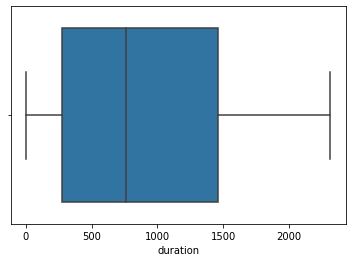

In [43]:
sns.boxplot(df['duration']);

In [44]:
%%time

params_lclass = {'logisticregression__penalty': ['l1', 'l2'],
                 'logisticregression__max_iter': (100, 200),
                 'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

grid_search_lclass = GridSearchCV(pipeline_lclass,
                                  params_lclass,
                                  cv=5,
                                  scoring='roc_auc')

grid_search_lclass.fit(features_train, target_train)


CPU times: user 10.8 s, sys: 9.14 s, total: 20 s
Wall time: 20 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['duration']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='infrequent_if_exist',
                                                                                       sparse=False),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=29012024,
                                                           solver='liblinear'))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                         'logisticregression__max_iter': (100, 200),
                         'logisticregression__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [45]:
print(f'Лучшие параметры: {grid_search_lclass.best_params_} \n'
      f'Лучший результат AUC-ROC: {grid_search_lclass.best_score_:.3f}')

Лучшие параметры: {'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2'} 
Лучший результат AUC-ROC: 0.748


Метрика AUC-ROC равна 0.748. Этого недостаточно, для рекомендации модели нам нужно минимум 0.85.

### CatBoostClassifier

Обучим модель градиентоного бустинга CatBoostClassifier. Кодировать категориальные колонки не будем, просто при инициилизации модели передадим ей список таких колонок, так как у CatBoostClassifier есть свой собственный кодировщик категориальных признаков, который называется CatBoost Encoder. Он автоматически обрабатывает категориальные признаки во время обучения модели CatBoostClassifier.

In [46]:
%%time

model = CatBoostClassifier(cat_features=cat_columns,
                           loss_function='Logloss',
                           verbose=False,
#                            class_weights={
#                                0: 1.0,
#                                1: 1.0
#                            },
                           random_state=RANDOM_STATE)

param_grid = {'depth': [2, 3, 4],
              'iterations': [100, 1000],
              'learning_rate': [0.1, 1],
              'reg_lambda': [0.1, 0.5, 1.0]}

grid_search_catboost = GridSearchCV(
    model,
    param_grid,
    cv=5,
    n_jobs = -1,
    scoring='roc_auc'
)

grid_search_catboost.fit(features_train, target_train)

print(f'Лучшие параметры: {grid_search_catboost.best_params_} \n'
      f'Лучший результат AUC-ROC: {grid_search_catboost.best_score_:.3f}')

Лучшие параметры: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.1, 'reg_lambda': 0.1} 
Лучший результат AUC-ROC: 0.938
CPU times: user 4min 57s, sys: 14.4 s, total: 5min 12s
Wall time: 7min 24s


Сохраним лучшую модель в отдельную переменную.

In [47]:
catboost_model = grid_search_catboost.best_estimator_

### LGBMRClassifier

In [48]:
%%time

model = LGBMClassifier(objective='binary',
                       metric='binary_logloss',
                       force_row_wise=True,
#                        class_weight='balanced',
                       verbosity=-1)

param_grid = {'max_depth': [2, 3, 4],
              'n_estimators': [100, 200],
              'learning_rate': [0.1, 1],
              'reg_lambda': [0.1, 0.5, 1.0]}

grid_search_lgbm = GridSearchCV(
    model,
    param_grid,
    cv=5,
    n_jobs = -1,
    scoring='roc_auc'
)

grid_search_lgbm.fit(features_train_lgbm, target_train)

print(f'Лучшие параметры: {grid_search_lgbm.best_params_} \n'
      f'Лучший результат AUC-ROC: {grid_search_lgbm.best_score_:.3f}')

Лучшие параметры: {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 200, 'reg_lambda': 0.1} 
Лучший результат AUC-ROC: 0.924
CPU times: user 1min 44s, sys: 0 ns, total: 1min 44s
Wall time: 1min 45s


Сохорарним лучшую модель в отдельную переменную.

In [49]:
lreg_model = grid_search_lgbm.best_estimator_

## Выбор лучшей модели и тестирование

### Выбор лучшей модели

Мы обучили три модели, выведем на экран таблицу с метрикой AUC-ROC каждой модели:

In [64]:
table = pd.DataFrame(index = ['Логистическая регрессия', 'LightGBM', 'Catboost'],
                     columns=['AUC-ROC'],
                     data=[[f'{grid_search_lclass.best_score_:.3f}'],
                           [f'{grid_search_lgbm.best_score_:.3f}'],
                           [f'{grid_search_catboost.best_score_:.3f}']])
table

,AUC-ROC
Логистическая регрессия,0.748
LightGBM,0.924
Catboost,0.938


Таким образом, в качестве лучшей модели мы выберем модель CatBoostClassifier. Она показала результат 0.93.8 на тестовых данных, при кросс-валидационной оценке. \
Данную модель мы выберем для тестирования.

### Тестирование и метрики

Получим предсказания модели на тестовой выборке и выведем метрики accuracy и AUC-ROC. \
Также выведем на экран график ROC-кривой и матрицу ошибок, посчитаем точность и полноту и посмотрим на признаки, которые модель посчитала как наиболее важные при прогнозе.

#### Тестирование, accuracy и ROC кривая

Accuracy модели на обучающей выборке: 0.945
AUC-ROC: 0.929


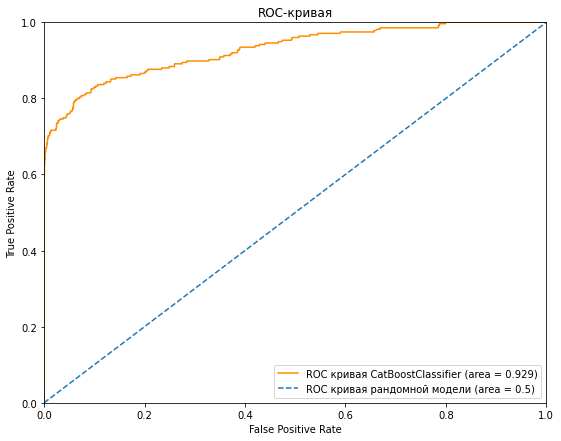

In [51]:
preds = catboost_model.predict(features_test)
probs = catboost_model.predict_proba(features_test)
prob = probs[:, 1]
roc_auc = roc_auc_score(target_test, prob)
accuracy = accuracy_score(target_test, preds)
print(f'Accuracy модели на обучающей выборке: {accuracy:.3f}\nAUC-ROC: {roc_auc:.3f}')

fpr, tpr, thresholds = roc_curve(target_test, prob)
plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='darkorange', label='ROC кривая CatBoostClassifier (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='ROC кривая рандомной модели (area = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC-кривая");

Метрика AUC-ROC на тестовых данных ожидаемо получилась немного хуже, чем на кросс-валидационных. Accuracy - 0.94.5, это значит, что модель верно определила 94.5% данных, но так как у нас несбалансированная выборка, данная метрика не годится для оценки качества предсказаний модели.

#### Матрица ошибок, точность и полнота

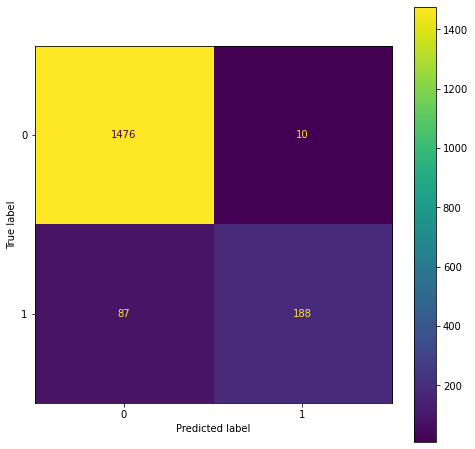

In [52]:
cm = confusion_matrix(target_test, preds)

cm_display = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax)

plt.show()

- 1476 - это TN (True Negative) количество примеров, для которых модель правильно определила класс 0, то есть что данные пользователи останутся клиентами компании.
- 10 - это FN (False Negative) - количество примеров, для которых модель неправильно предсказала класс 1, иными словами, модель в 7 случаях предсказала, что клиенты уйдут, в то время как они не собирались уходить.
- 87 - это FP (False Positive) - количество примеров, для которых модель неправильно предсказала класс 0, то есть модель определила в итоге ушедших клиентов, как не собирающихся разрывать договор.
- 188 - это TP (True Positive) - количество примеров, для которых модель правильно предсказала класс 1, то есть она правильно предсказала, что клиенты собираются разорвать договор. 

Посчитаем точность и полноту.

In [53]:
# Расчет полноты
recall_score(target_test, preds)

0.6836363636363636

**Полнота** — это доля _TP_-ответов среди всех, у которых истинная метка 1. Иными словами, это доля (в нашем случае 68.4%) правильно орпеделенных клинетов, которые собираются разорвать договор.

68.3% ушедших клиентов компания могла бы удержать предоставив им купоны или выгодные предложения. И 31.6% клиентов модель не смогла выявить.

In [54]:
# Расчет точности
precision_score(target_test, preds)

0.9494949494949495

**Точность** показывает, насколько точно модель предсказывает положительный класс.  Иными словами, какая доля из предсказанных моделью как собирающихся уйти клиентов, действительно ушли. 

В контексте работы компании, точность может быть полезна, чтобы определить, насколько рационально были потрачены средства на купоны. В нашем случае, только 5% купонов будут выданы клиентам, которые не собираются уходить. 

#### Важность признаков

Посмотрим, как CatBoostClassifier оценил важность признаков.

In [55]:
feature_importances = pd.Series(
    data=catboost_model.get_feature_importance(),
    index=features_test.columns
).sort_values(ascending=False)

feature_importances

duration            78.33
type                 5.14
payment_method       4.59
streaming_movies     4.23
multiple_lines       3.84
partner              1.69
dependents           1.00
paperless_billing    0.81
senior_citizen       0.38
dtype: float64

Выведем графиком.

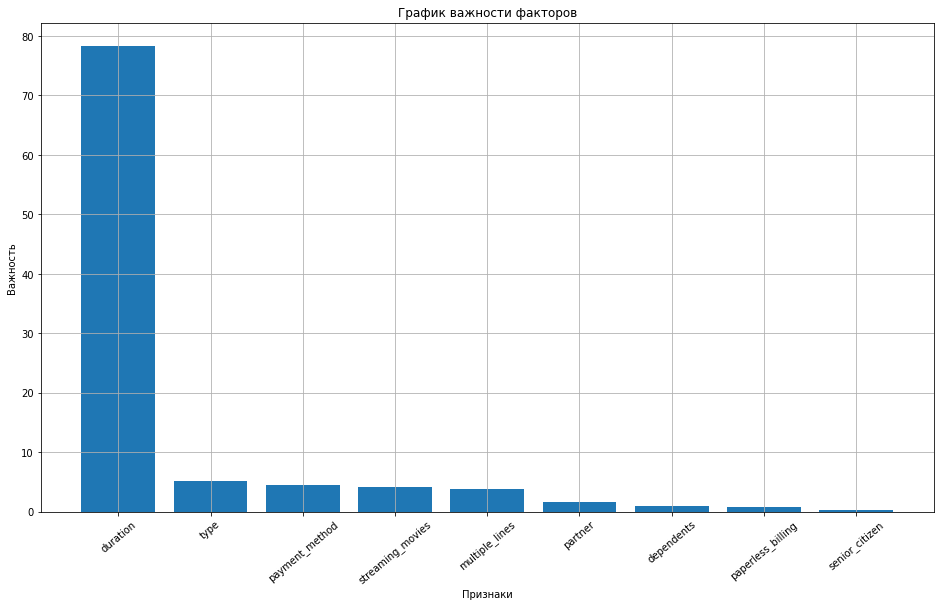

In [56]:
x = np.arange(len(features_test.columns))

plt.figure(figsize=(16, 9))
plt.bar(x, feature_importances)
plt.xticks(x, feature_importances.index, rotation=40)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('График важности факторов')
plt.grid();

##### duration

Наиболее высоко, модель оценила параметр продолжительности контракта. То есть модель считает, что чем дольше пользователь является абонентом компании, тем меньше вероятность, что он разорвет договор. 

Посмотрим и сравним гистограммы продолжительности контракта у ушедших и оставшихся клиентов.

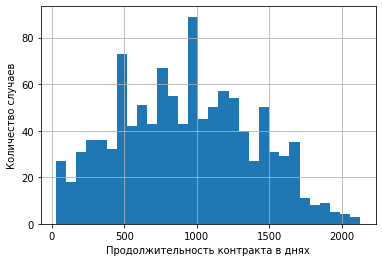

In [57]:
departed_customers = df.query('breaking_contract == 1')
retained_customers = df.query('breaking_contract == 0')

# Клиенты которые ушли
departed_customers['duration'].hist(bins=30)
plt.xlabel('Продолжительность контракта в днях')
plt.ylabel('Количество случаев');

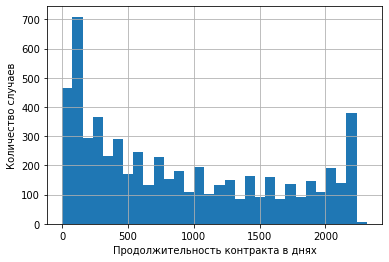

In [58]:
# Клиенты которые остались
retained_customers['duration'].hist(bins=30)
plt.xlabel('Продолжительность контракта в днях')
plt.ylabel('Количество случаев');

Форма распределения разная, у клиентов, которые ушли, наиболее преобладают клиенты со средней длительностью контракта, от 450 до 1700 дней, в то время в оставшихся клиентах, доля таких пользователей гораздо меньше. В то же время в оставшихся клиентах намного больше доля клиентов с наиболее длительными контрактами. \
Если вспомнить график распределения пользователей, где в последние полтора года в 2.5 раза возросло количество новых клиентов, и сравнить пропорции, можно сделать вывод, что новых пользователей хорошо удерживают, возможно в это время еще действуют стартовые акционные предложения. Абоненты с наиболее длительными контрактами также менее склонны к прекращению сотрудничества и уходят в основном пользователи со средней продолжительностью контракта.

##### type

На третьем месте признак type, который показывает, за какой период сразу предпочитает платить клиент, есть три варианта:
- Помесячная оплата
- За год вперед
- За два года вперед

Посмотрим на распределение этих категорий у ушедших и оставшихся клиентов.

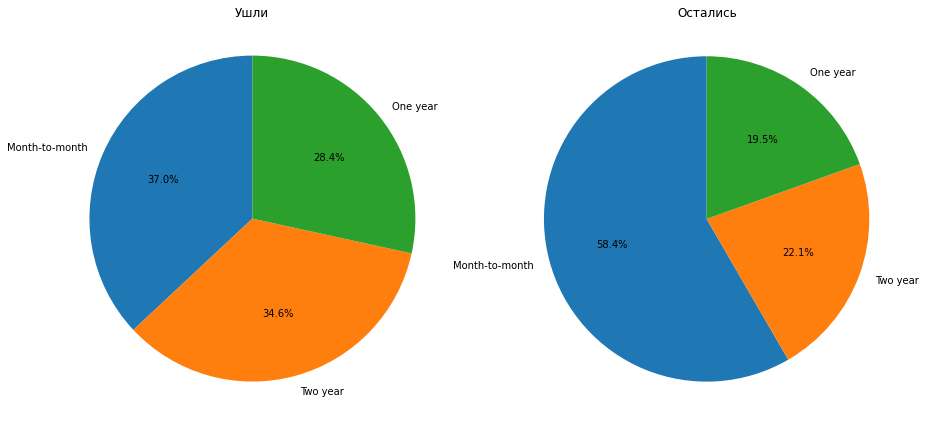

In [60]:
departed_customers_type = departed_customers['type'].value_counts()
retained_customers_type = retained_customers['type'].value_counts()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
ax1.pie(departed_customers_type.values, labels=departed_customers_type.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Ушли')
ax1.axis('equal')

ax2.pie(retained_customers_type.values, labels=retained_customers_type.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Остались')
ax2.axis('equal')

plt.tight_layout();

Можно увидеть, что в ушедших клиентах больше доля тех, кто платил сразу за один или два года, при этом доля двухлетних больше, чем с оплатой за один год. \
Возможно большой чек за несколько лет чаще побуждает абонентов искать более выгодные предложения.

##### payment_method

На третьем месте признак payment_method, который показывает, как предпочитает платить клиент, есть четыре варианта:
- Электронный чек
- Чек по почте
- Автоматическая оплата по кредитной карте
- Автоматический банковский перевод

Посмотрим на распределение этих категорий у ушедших и оставшихся клиентов.

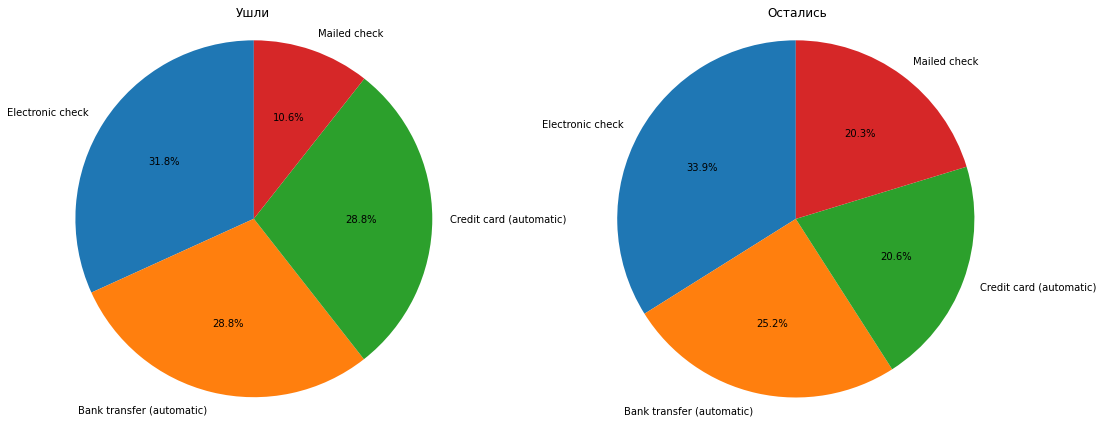

In [61]:
departed_customers_type = departed_customers['payment_method'].value_counts()
retained_customers_type = retained_customers['payment_method'].value_counts()

labels = departed_customers_type.index
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax1.pie(departed_customers_type.values, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Ушли')
ax1.axis('equal')

ax2.pie(retained_customers_type.values, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Остались')
ax2.axis('equal')

plt.tight_layout();

Можно увидеть, что в ушедших клиентах больше половины тех, кто платит автоматическими переводами с кредитной карты или банковского счета, и в половину меньше доля тех, кто платит почтовыми чеками.

## Вывод

Наша задача звучала так:

    Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов. Метрика AUC-ROC должна быть не менее 0.85.

В ходе работы мы провели обзор, предобработку и исследовательский анализ данных, объединили предоставленные нам датафреймы, обогатили, подготовили признаки и обучили три модели:
- Логистическую регрессию
- CatBoostClassifier
- LGBMClassifier

Эти модели показали результаты метрики AUC-ROC:

In [62]:
table

,AUC-ROC
Логистическая регрессия,0.748
LightGBM,0.924
Catboost,0.938


Лучшие результаты показала модель CatBoostClassifier. В ходе тестирования, данная модель показала незначительно худший результ - AUC-ROC составила 0.928. Accuracy данной модели составила - 0.945. Выборка у нас несбалансирована, поэтому аccuracy не подходит для оценки точности модели, AUC-ROC же не чувствителен к дисбалансу классов,  благодаря тому, что опирается на точность и полноту предсказаний модели.

В ходе тестирования мы измерили полноту и точность предсказания моделии:
- Точность модели составила 95%. Точность показывает, какая доля из предсказанных моделью как собирающихся уйти клиентов, действительно ушли. В текущем контексте, точность может быть полезна, чтобы определить, насколько рационально были потрачены средства на купоны. В нашем случае, только 5% купонов будут выданы клиентам, которые не собираются уходить. 
- Полнота составила 68.4%. Полнота показывает, долю правильно орпеделенных клинетов, которые собираются разорвать договор, от общего их числа. С помощью нашей модели, компания сможет определить 61.6% планирующих уйти клиентов, предложить им более выгодные условия или промокоды, таким образом компания сможет бороться с оттоком клиентов.

Также мы вывели признаки, которые модель посчитала наиболее важными, такими признаками оказались:
- Продолжительность контракта - этот признак выведен нами на этапе обогащения данных, он показывает продолжительность контракта в днях. Выведя гистограммы ушедших и оставшихся абонентов по этому признаку, мы пришли к выводу, что наименее подвержены уходу пользователи с продолжительностью контракта менее 450 дней и более 1800 дней. Наиболее подвержены уйти абоненты со сроком контракта в районе 1000 дней. 
- Тип оплаты. Данный признак показыват, на какой срок клиент вносит предоплату услуг: на месяц вперед, на год или на два года. Выведя круговые диаграммы мы пришли к выводу, что более подвержены уходу клиенты с оплачивающие за один и два года вперед. Причем доля клиентов,  оплачивающих за два года вперед больше, чем тех, кто вносит предоплату за один год. Это может говорить о том, что клиенты, видя большой суммарный чек, чаще задумываются о более выгодных условиях, поэтому могут обратиться к конкурентам за более выгодными акционными условиями. 
- Тип платежа. Этот признак показывает, как удобнее платить клиенту. На графиках мы увидели, что в ушедших клиентах больше половины тех, кто платит автоматическими переводами с кредитной карты или банковского счета, и в половину меньше доля тех, кто платит почтовыми чеками.

Всех этих клиентов можно было бы удержать, вовремя предложив им купоны или специальные выгодные условия. Наша модель будет полезна при определении таких клиентов, она может помочь сократить отток клиентов на 68.4%, при этом она очень точна, всего 5% купонов из всего объема предложений, могут быть предложены не целевым клеинтам. Такая точность поможет сохратить расходы, сделать предложения более таргетированными.

Задачу бизнеса мы выполнили. Метрика AUC-ROC модели составила 92.8% на тестовой выборке.